In [17]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# path
path_dir = 'C:/Users/USER/.kaggle/competitions/champs-scalar-coupling/'
file_list = os.listdir(path_dir)
file_list

['dipole_moments.csv',
 'magnetic_shielding_tensors.csv',
 'mulliken_charges.csv',
 'potential_energy.csv',
 'sample_submission.csv',
 'scalar_coupling_contributions.csv',
 'structures.csv',
 'structures.zip',
 'test.csv',
 'train.csv']

## 1. Load Train/Test Data
**Columns**
- molecule_name : 분자 이름 
- atom_index_0 / atom_index_1 : 원자 인덱스
- type
- Coupling Constant(결합상수) : 물리적 상호작용(여기서는 원자 간)의 세기를 나타내는 상수, 결합상수가 1일때 완전결합이라고 함

In [2]:
train_df = pd.read_csv(path_dir+'train.csv')
test_df = pd.read_csv(path_dir+'test.csv')   # target = 'scalar_coupling_constant'

print('Length of train set: {}'.format(len(train_df)))
print('Length of test set: {}'.format(len(test_df)))

Length of train set: 4658147
Length of test set: 2505542


In [3]:
print('Unique molecule of train set: {}'.format(len(train_df['molecule_name'].unique())))
train_df.head()

Unique molecule of train set: 85003


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [4]:
print('Unique molecule of test set: {}'.format(len(test_df['molecule_name'].unique())))
test_df.head()

Unique molecule of test set: 45772


,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


## 2. EDA

#### 2.1 Distribution of Target ('scalar_coupling_constant')
- Min Value : -36.2186
- Max Value : 204.88
- 대부분이 -20 ~ +20 사이에 존재
- 작은 분포로 80 ~ 100 사이에 존재

Min Value of Target : -36.2186
Max Value of Target : 204.88


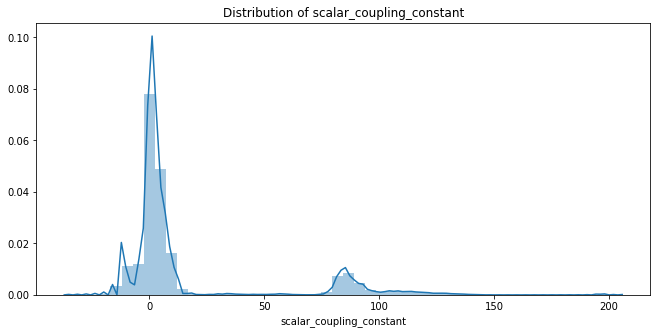

In [5]:
# Distribution of target
print('Min Value of Target : {}'.format(train_df['scalar_coupling_constant'].min()))
print('Max Value of Target : {}'.format(train_df['scalar_coupling_constant'].max()))

plt.figure(figsize=(11, 5))
sns.distplot(train_df['scalar_coupling_constant'])
plt.title('Distribution of scalar_coupling_constant')
plt.show()

#### 2.2 Distribution of 'scalar_coupling_constant' by type
- '1JHC' type이 상대적으로 높은 scalar coupling 범위에 분포(+66.6 ~ +204.8) 
- '2JHH' type이 상대적으로 낮은 scalar coupling 범위에 분포(-35.1 ~ +11.8

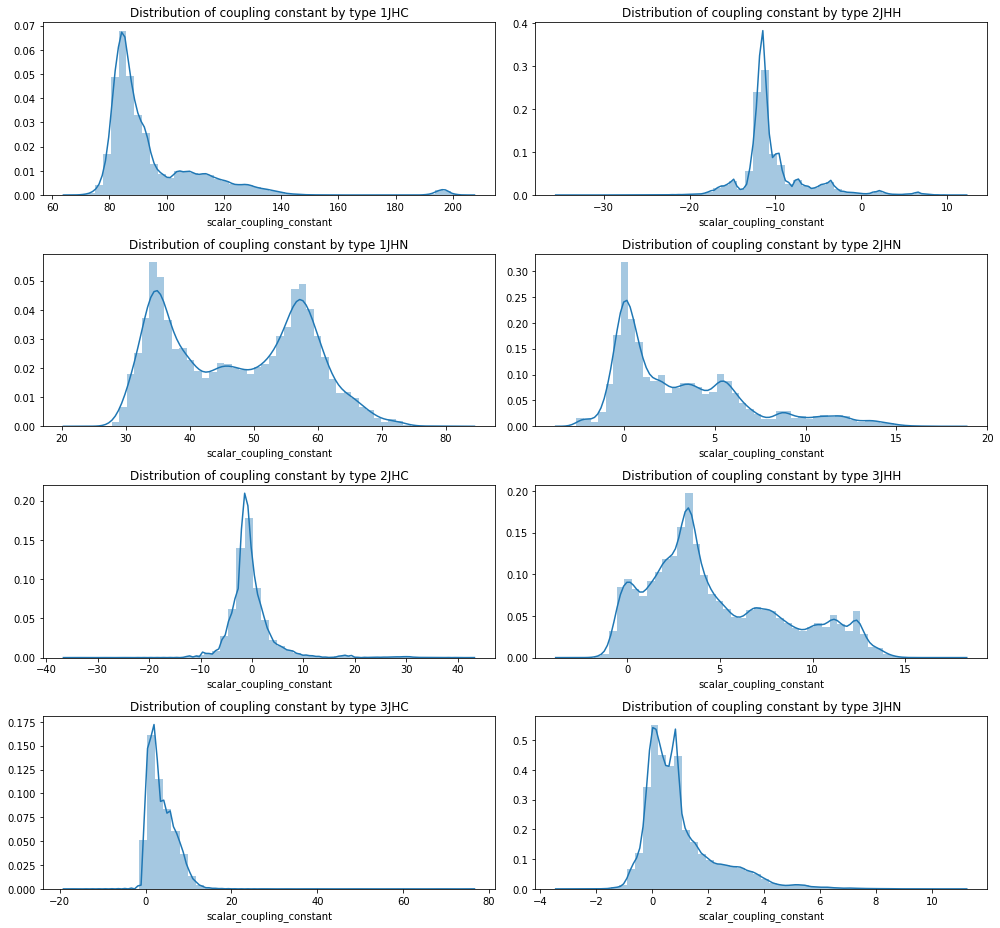

In [6]:
# Distribution of 'scalar_coupling_constant' by type
plt.figure(figsize=(14, 13))
for i, t in enumerate(train_df['type'].unique()):
    plt.subplot(4,2, i+1)
    sns.distplot(train_df[train_df['type'] == t]['scalar_coupling_constant'])
    plt.title('Distribution of coupling constant by type '+ t)
    plt.tight_layout()

#### 2.3 Count by 'type'
- 3JHC, 2JHC, 1JHC, 3JHH, 2JHH, 3JHN, 2JHN, 1JHN 순서로 높음

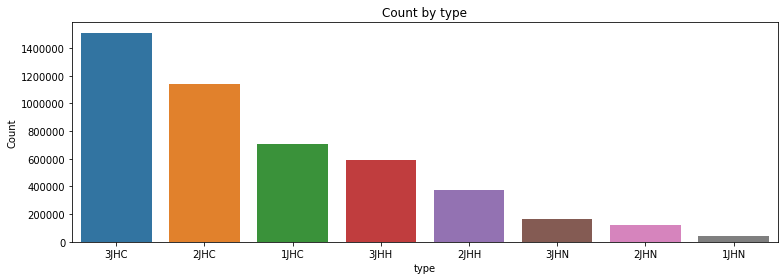

In [7]:
# Count by 'type'
type_index = train_df['type'].value_counts().index
type_cnt = train_df['type'].value_counts()

plt.figure(figsize=(11, 4))
sns.barplot(x=type_index, y=type_cnt)
plt.xlabel('type'); plt.ylabel('Count')
plt.title('Count by type')
plt.tight_layout()

#### 2.4 Count by atom index 0, 1
- atom index 0의 경우 9 ~ 18번이 가장 많이 분포
- atom index 1의 경우 1 ~ 8번이 가장 많이 분포

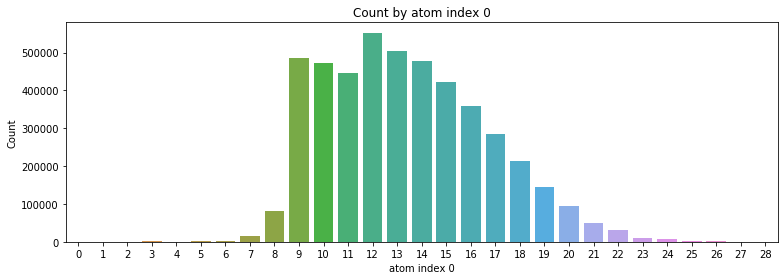

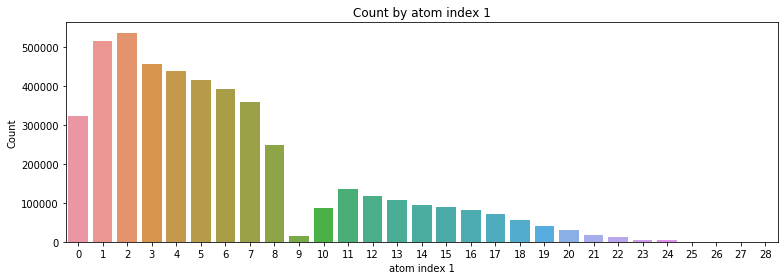

In [8]:
# Count by atom index 0, 1
for i in [0, 1]:
    atom_index = train_df['atom_index_'+str(i)].value_counts().index
    atom_cnt = train_df['atom_index_'+str(i)].value_counts()
    
    plt.figure(figsize=(11, 4))
    sns.barplot(x=atom_index, y=atom_cnt)
    plt.xlabel('atom index '+str(i)); plt.ylabel('Count')
    plt.title('Count by atom index '+str(i))
    plt.tight_layout()

## 3. Load Structures Data
**Columns**
- molecule_name
- atom_index
- atom
- x, y, z axis of atom

In [9]:
structures_df = pd.read_csv(path_dir+'structures.csv')

print('Length of test set: {}'.format(len(structures_df)))
structures_df.head()

Length of test set: 2358657


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


#### 3.1. 3Dimension plot by Molecule

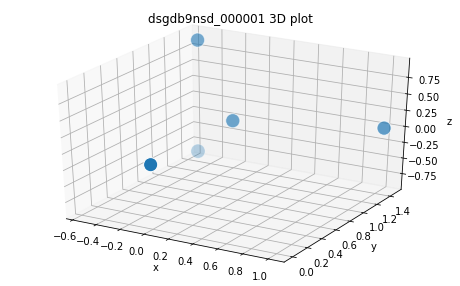

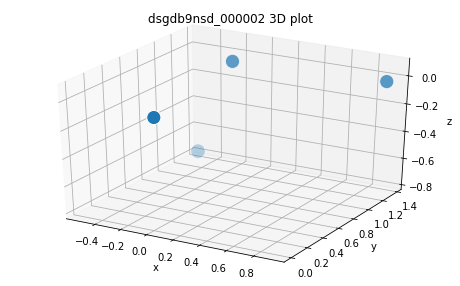

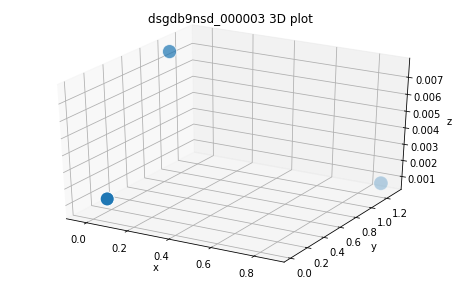

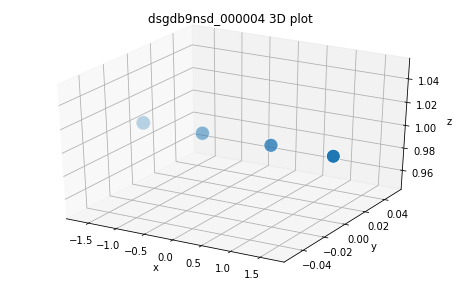

In [10]:
for name in structures_df['molecule_name'].unique()[:4]:
    structures_molecule =structures_df[structures_df['molecule_name'] == name]

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(structures_molecule['x'], structures_molecule['y'], structures_molecule['z'], s=200, edgecolors='white')
    ax.set_title(str(name)+ ' 3D plot')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

## 4. Preprocessing
#### 4.1. Merge Train&Test - Structures Data

In [11]:
def mapping_atom_index(df, atom_idx):
    atom_idx = str(atom_idx)
    df = pd.merge(df, structures_df,
                  left_on  = ['molecule_name', 'atom_index_'+atom_idx],
                  right_on = ['molecule_name',  'atom_index'],
                 how = 'left')
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': 'atom_'+atom_idx,
                            'x': 'x_'+atom_idx,
                            'y': 'y_'+atom_idx,
                            'z': 'z_'+atom_idx})
    return df

In [12]:
train_merge = mapping_atom_index(train_df, 0)
train_merge = mapping_atom_index(train_merge, 1)

test_merge = mapping_atom_index(test_df, 0)
test_merge = mapping_atom_index(test_merge, 1)

In [13]:
train_tmp = train_merge[['id','molecule_name','type']]
test_tmp = test_merge[['id','molecule_name','type']]

train_merge.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


#### 4.2. Derived variables - 'Distance'
- distance between *x axis* of atom index
- distance between *y axis* of atom index
- distance between *z axis* of atom index
- distance between *atom*

In [14]:
def dist_between_atom(df):
    # distance between axis of atom
    df['x_dist'] = (df['x_0'] - df['x_1'])**2
    df['y_dist'] = (df['y_0'] - df['y_1'])**2
    df['z_dist'] = (df['z_0'] - df['z_1'])**2
    
    # distance between atom
    df['atom_dist'] = (df['x_dist']+df['y_dist']+df['z_dist'])**0.5
    
    return df
    
train_dist = dist_between_atom(train_merge)
test_dist = dist_between_atom(test_merge)

In [15]:
train_dist.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,x_dist,y_dist,z_dist,atom_dist
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,0.000220,1.192105,0.000036,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.019253,2.160261,0.000003,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,0.294812,2.112831,0.771973,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,0.276638,2.085032,0.817978,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.049455,0.142844,0.000060,1.091952


#### 4.3. Label encoding 
- type, atom_0, atom_1

In [18]:
# Label encoding
categorical_features = ['type', 'atom_0', 'atom_1']
for col in categorical_features:
    le = LabelEncoder()
    le.fit(list(train_dist[col].values) + list(test_dist[col].values))
    train_dist[col] = le.transform(list(train_dist[col].values))
    test_dist[col] = le.transform(list(test_dist[col].values))

In [19]:
train_le = train_dist.copy()
test_le = test_dist.copy()

In [20]:
train_le.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,x_dist,y_dist,z_dist,atom_dist
0,0,dsgdb9nsd_000001,1,0,0,84.8076,0,0.002150,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,0.000220,1.192105,0.000036,1.091953
1,1,dsgdb9nsd_000001,1,2,3,-11.2570,0,0.002150,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1.019253,2.160261,0.000003,1.783120
2,2,dsgdb9nsd_000001,1,3,3,-11.2548,0,0.002150,-0.006031,0.001976,1,-0.540815,1.447527,-0.876644,0.294812,2.112831,0.771973,1.783147
3,3,dsgdb9nsd_000001,1,4,3,-11.2543,0,0.002150,-0.006031,0.001976,1,-0.523814,1.437933,0.906397,0.276638,2.085032,0.817978,1.783157
4,4,dsgdb9nsd_000001,2,0,0,84.8074,0,1.011731,1.463751,0.000277,0,-0.012698,1.085804,0.008001,1.049455,0.142844,0.000060,1.091952


#### 4.4. Standardization
- z = (x - u) / s

In [21]:
# train
train_data = train_le.drop(['id','molecule_name','scalar_coupling_constant'], axis=1)
train_target = train_le['scalar_coupling_constant']
# test
test_data = test_le.drop(['id','molecule_name',], axis=1)

In [22]:
# z-score standardization
train_scale = (train_data - train_data.mean()) / train_data.mean()
train_scale = train_scale.fillna(0)
test_scale = (test_data - train_data.mean()) / train_data.mean()

#### 4.5. Variable Correlations

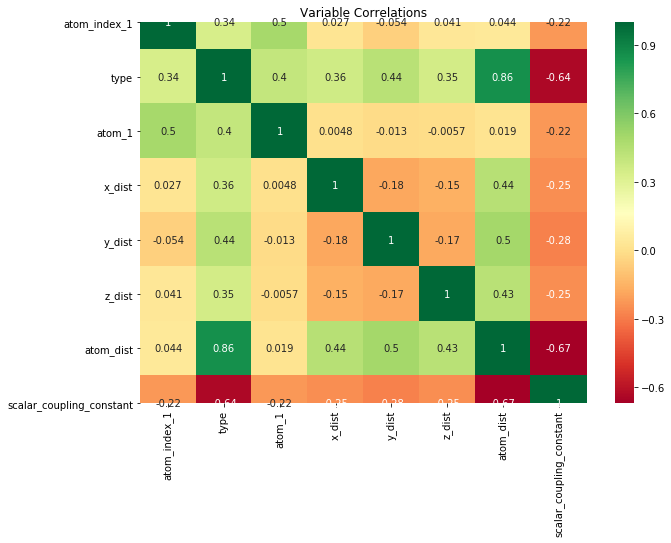

In [23]:
train_corr = train_scale.copy()
train_corr['scalar_coupling_constant'] = train_target
corrmat = train_corr.corr()
top_corr_features = corrmat.index[abs(corrmat['scalar_coupling_constant']) >= 0.1]

plt.figure(figsize=(10,7))
sns.heatmap(train_corr[top_corr_features].corr(), annot=True, cmap="RdYlGn")
plt.title('Variable Correlations')
plt.show()

## 5. Training Model

#### 5.1. Training by 'type' through LightGBM

In [24]:
train_scale = train_scale.drop('type', axis=1)
train_scale['type'] = train_tmp['type']
train_scale['scalar_coupling_constant'] = train_target

test_scale = test_scale.drop('type', axis=1)
test_scale[['id', 'type']] = test_tmp[['id', 'type']]

In [25]:
score_by_type = []    # List of Validation score by type 
feature_importance_df = []
test_pred_df = pd.DataFrame(columns=['id', 'scalar_coupling_constant'])   # Dataframe for submission

# Extract data by type
types = train_tmp['type'].unique()
for typ in types:
    
    print('---Type of '+str(typ)+'---')
    train = train_scale[train_scale['type'] == typ]
    target = train['scalar_coupling_constant']
    train = train.drop(['type','scalar_coupling_constant'], axis=1)
    
    # Split train set / valid set
    x_train, x_val, y_train, y_val = train_test_split(train, target, random_state=42)
    
    # LightGBM
    categorical_features = ['atom_0','atom_1']
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
    lgb_val = lgb.Dataset(x_val, y_val, categorical_feature=categorical_features)

    # Parameters of LightGBM
    params = {'num_leaves': 128,
              'min_child_samples': 79,
              'objective': 'regression',
              'max_depth': 9,
              'learning_rate': 0.1,
              "boosting_type": "gbdt",
              "subsample_freq": 1,
              "subsample": 0.9,
              "bagging_seed": 11,
              "metric": 'mae',
              "verbosity": -1,
              'reg_alpha': 0.13,
              'reg_lambda': 0.36,
              'colsample_bytree': 1.0
             }
    # Training
    lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val], 
                          num_boost_round=20000,    # Number of boosting iterations.
                          early_stopping_rounds=500,    # early stopping for valid set
                          verbose_eval=2500)    # eval metric on the valid set is printed at 1000 each boosting
    
    # Feature Importances
    feature_importance = lgb_model.feature_importance()
    df_fi = pd.DataFrame({'columns':x_train.columns, 'importances':feature_importance})
    df_fi = df_fi[df_fi['importances'] > 0].sort_values(by=['importances'], ascending=False)
    feature_importance_df.append(df_fi)
    
    # Predict Validation set
    score_by_type.append(list(lgb_model.best_score['valid_1'].values()))
    
    # Predict Test set
    test = test_scale[test_scale['type'] == typ]
    test_id = test['id']
    test = test.drop(['id','type'], axis=1)
    
    test_preds = lgb_model.predict(test)
    test_pred_df = pd.concat([test_pred_df, pd.DataFrame({'id':test_id, 'scalar_coupling_constant':test_preds})], axis=0)

---Type of 1JHC---


C:\Miniconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Miniconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[2500]	training's l1: 2.77031	valid_1's l1: 3.67976
[5000]	training's l1: 2.19648	valid_1's l1: 3.59536
[7500]	training's l1: 1.81083	valid_1's l1: 3.56509
[10000]	training's l1: 1.52513	valid_1's l1: 3.55207
[12500]	training's l1: 1.30189	valid_1's l1: 3.54733
Early stopping, best iteration is:
[12398]	training's l1: 1.31009	valid_1's l1: 3.54716
---Type of 2JHH---
Training until validation scores don't improve for 500 rounds.
[2500]	training's l1: 0.599486	valid_1's l1: 0.930904
[5000]	training's l1: 0.429952	valid_1's l1: 0.920848
Early stopping, best iteration is:
[6444]	training's l1: 0.363731	valid_1's l1: 0.919744
---Type of 1JHN---
Training until validation scores don't improve for 500 rounds.
[2500]	training's l1: 0.574269	valid_1's l1: 1.869
Early stopping, best iteration is:
[2790]	training's l1: 0.51238	valid_1's l1: 1.86748
---Type of 2JHN---
Training until validation scores don't improve for 500 rounds.
[2500]

#### 5.2. Validation MAE by type

In [26]:
for typ, score in zip(types, score_by_type):
    print('Type {} valid MAE  : {}'.format(str(typ), score))

print('\nAverage of valid MAE  : {}'.format(np.mean(score_by_type)))

Type 1JHC valid MAE  : [3.5471584407190475]
Type 2JHH valid MAE  : [0.9197439377103146]
Type 1JHN valid MAE  : [1.8674786631630775]
Type 2JHN valid MAE  : [1.255876548899015]
Type 2JHC valid MAE  : [1.7202390170123096]
Type 3JHH valid MAE  : [1.0051635344922942]
Type 3JHC valid MAE  : [1.2023186835296467]
Type 3JHN valid MAE  : [0.4975260038664571]

Average of valid MAE  : 1.5019381036740203


#### 5.3. Feature Importances Plot by Type

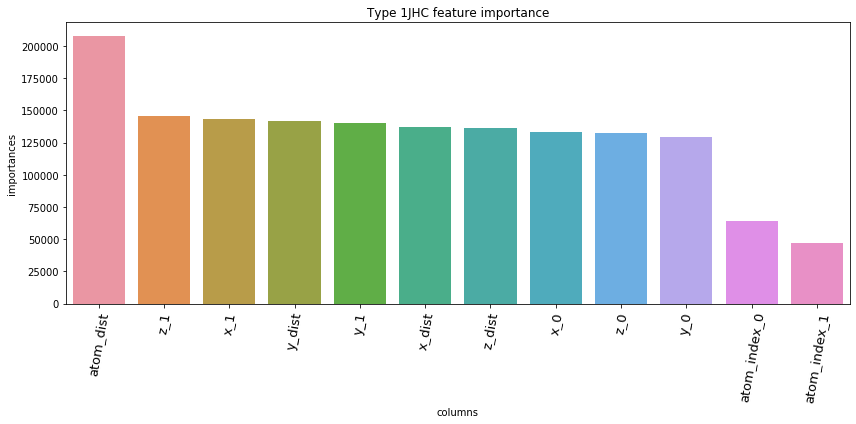

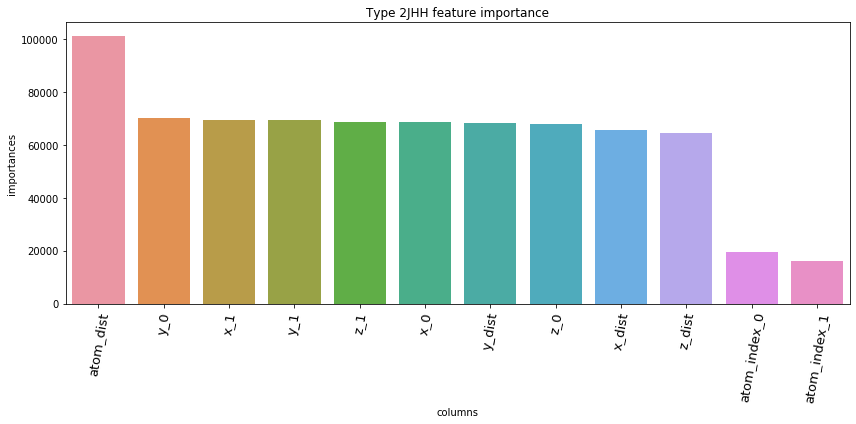

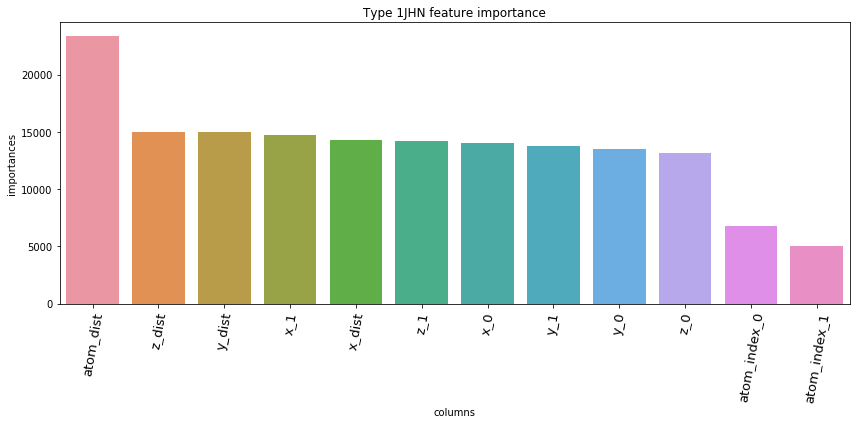

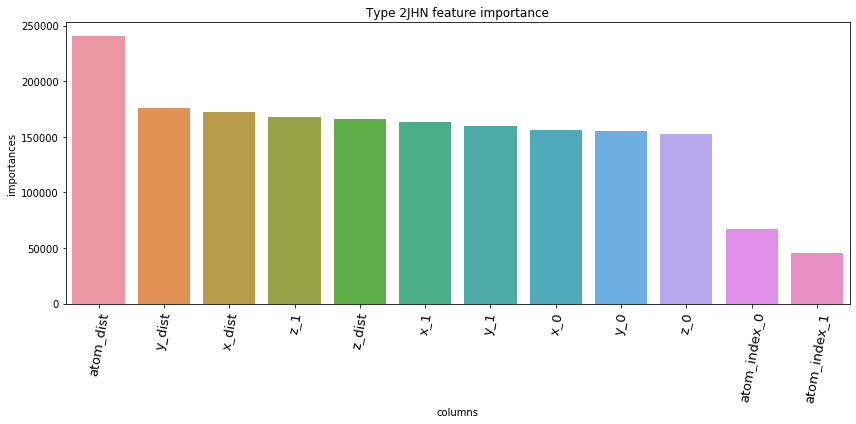

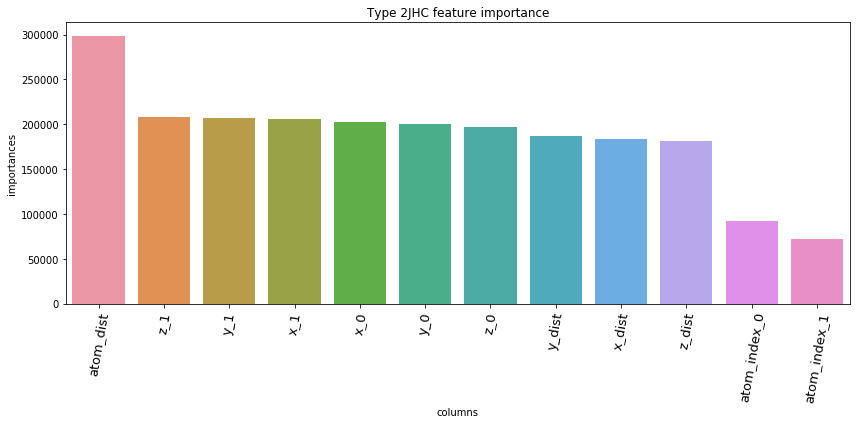

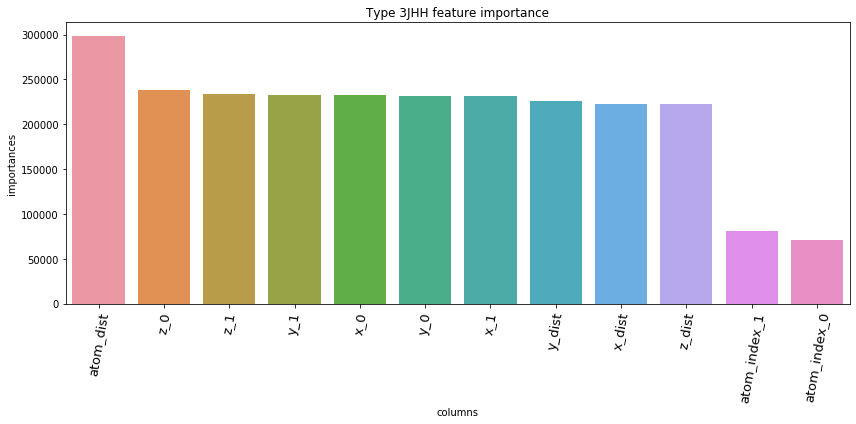

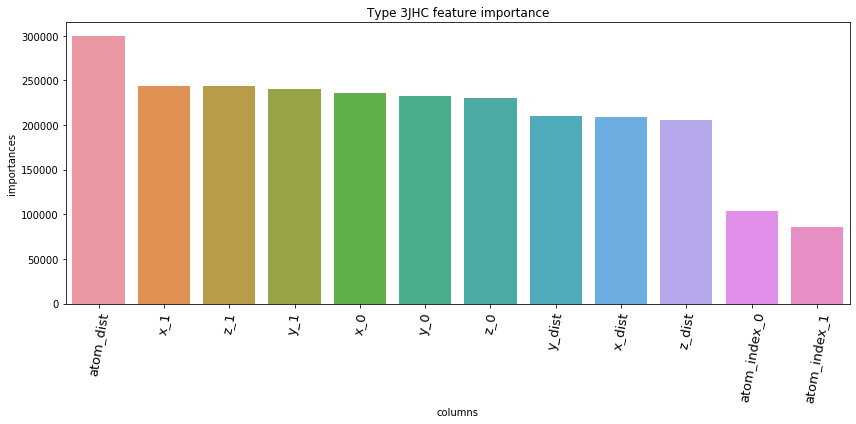

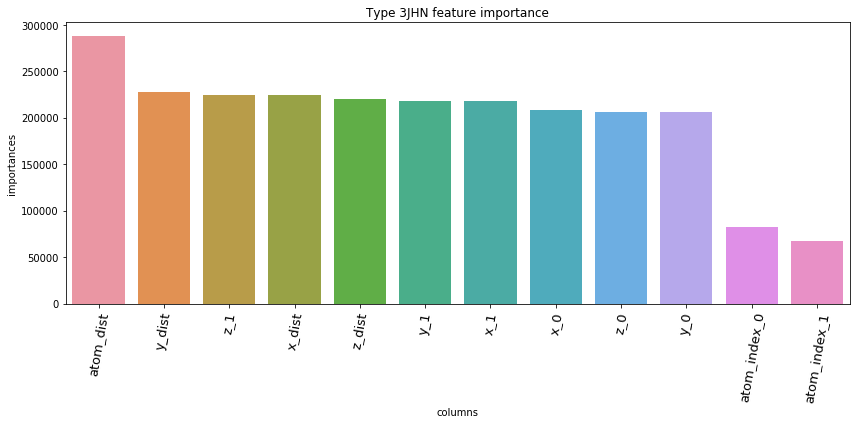

In [27]:
for typ, df_fi in zip(types, feature_importance_df):
    fig = plt.figure(figsize=(12, 6))
    ax = sns.barplot(df_fi['columns'], df_fi['importances'])
    ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
    plt.title('Type '+str(typ)+' feature importance')
    plt.tight_layout()
    plt.show()

#### 5.4. Save prediction of test set to *.csv 

In [28]:
test_pred_df.head(10)

,id,scalar_coupling_constant
1,4658148,189.804447
3,4658150,183.930043
5,4658152,91.216363
9,4658156,90.702308
12,4658159,81.742595
15,4658162,96.473255
19,4658166,95.188708
22,4658169,89.153816
23,4658170,109.170185
31,4658178,104.822644


In [29]:
test_pred_df.to_csv('lgb_submission.csv', index=False)